In [1]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed
import qutip as qt

In [131]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega):
    flux = 0.435
    #snail parameters
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()
    
    
    #cavity1 parameters
    omega_c1 = 3*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 3
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 7*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 3
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()
    
    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)
    
    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
    energy0,U = np.linalg.eigh(H)
#     snailcc = SNAILCC(snail,cavity1,cavity2)
#     H0,Hc = snailcc.hamiltonian()
    
#     energy,U = np.linalg.eigh(H0)

    index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
    index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))
    detuning = energy0[index2]-energy0[index1]
    total_dim = dims*dimc1*dimc2
    H0 = Qobj(H)
    Hc = Qobj(Hc)
    psi0 = qt.basis(total_dim, index1)
    Iss = qt.qeye(dims)
    s0 = qt.basis(dims, 0)*(qt.basis(dims, 0).dag())
    cavity0 = qt.basis(dimc1, 0)*(qt.basis(dimc1, 0).dag())
    cavity1 = qt.basis(dimc1, 1)*(qt.basis(dimc1, 1).dag())
    cavity2 = qt.basis(dimc1, 2)*(qt.basis(dimc1, 2).dag())
    PP1 = qt.Qobj(np.array(qt.tensor(Iss, cavity0, cavity1)))
    PP2 = qt.Qobj(np.array(qt.tensor(Iss, cavity1, cavity0)))

    
    T = (2*np.pi)/omega
    omega1 = 4.83 * 2 * np.pi
    A1 = 0.01* 2 * np.pi
    args = {'w': omega,'w1':omega1}
    tlist = np.linspace(0, 100000 * T, 100000)  # Cover ten periods
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)],[Hc, lambda t, args: A1*np.cos(args['w1']*t)]] 
#     options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
    exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])

    return result,exp_P1,exp_P2

In [132]:
A = 0.2 * 2 * np.pi
omega =25.204831869962916
result,exp_P1,exp_P2 = energy_diff(A,omega)

In [133]:
dimc1 = 3
dims = 10
Ic = qt.qeye(dimc1)
Ns = qt.num(dims)
Ns = qt.Qobj(np.array(qt.tensor(Ns,Ic,Ic)))
exp_Ps = np.array([qt.expect(Ns, state) for state in result.states])

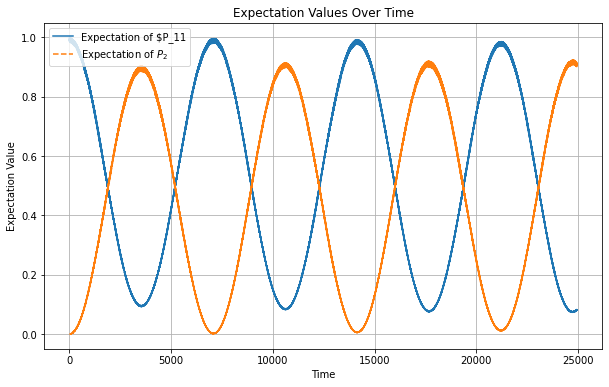

In [134]:
# Create the plot
plt.figure(figsize=(10, 6))
# plt.plot(tlist, exp_Ps, label='Expectation of $P_1$', )
plt.plot(tlist, exp_P1, label='Expectation of $P_11')
plt.plot(tlist, exp_P2, label='Expectation of $P_2$', linestyle='--')
# plt.plot(tlist, exp_P11, label='Expectation of $P_11')
# plt.plot(tlist, exp_P21, label='Expectation of $P_21$', linestyle='--')
# plt.xlim(2000,2100)

plt.title('Expectation Values Over Time')
plt.xlabel('Time')
plt.ylabel('Expectation Value')
plt.legend()
plt.grid(True)
plt.show()

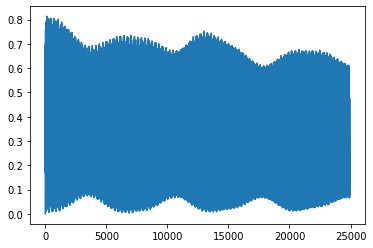

In [135]:
plt.plot(tlist, exp_Ps, label='Expectation of $P_1$', )

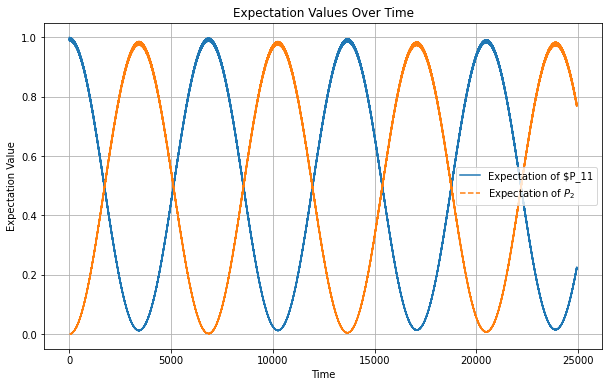

In [130]:
# Create the plot
plt.figure(figsize=(10, 6))
# plt.plot(tlist, exp_Ps, label='Expectation of $P_1$', )
plt.plot(tlist, exp_P1, label='Expectation of $P_11')
plt.plot(tlist, exp_P2, label='Expectation of $P_2$', linestyle='--')
# plt.plot(tlist, exp_P11, label='Expectation of $P_11')
# plt.plot(tlist, exp_P21, label='Expectation of $P_21$', linestyle='--')
# plt.xlim(2000,2100)

plt.title('Expectation Values Over Time')
plt.xlabel('Time')
plt.ylabel('Expectation Value')
plt.legend()
plt.grid(True)
plt.show()